#  **Predicting which positions in the NBA get "snubbed" for the all star game** #

Woojune Lee

## **Introduction:**##

In the current NBA, select players are chosen to participate in the all star game. These players are selected to be a part of the all star team by fans, NBA players, and a group of media representatives. Each year, many fans are unhappy about certain players not being selected to play in this all star game. Fans say that these unpicked players are "snubbed", meaning that they deserved to be participating in this event but was not picked. Fans of the NBA look at representative statistics of a player and feel that they should be in the all star game, primarily looking at points averages, rebounding averages, and assist averages. One look at popular social media after all star players are annouced shows fans making a case for snubbed players averaging more points that their picked counterpart.

A recurrent debate in this context is whether front-court players (forwards and centers) or back-court players (shooting guards and point guards) are more likely to be snubbed from this event. I wanted to dive deeper into the underlying statistics of the game and decide if there is a correlation between the amount of snubbed players depending on which positions they play.

Null Hypothesis: There no correlation between player position and all star selection.

Alternate Hypothesis: These is a correlation between player position and all star selection.



# **Data Curation**

In this project, we we collect data from every single NBA player from the 2023-2024 NBA season. This data is from nbastuffer.com. (Source: https://www.nbastuffer.com/2023-2024-nba-player-stats/)

This csv file contains core stats of every NBA player registered for the 2023-2024 NBA season, the season we will analyze.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, chi2_contingency

df = pd.read_csv('nba20232024.csv')
df = df.drop('RANK', axis=1) # all of the values of rank column were NaN
df = df.dropna() # dropping rows with missing values
df = df.reset_index(drop=True)


# display the cleaned dataframe's structure and the first few rows
df.head()

,NAME,TEAM,POS,AGE,GP,MPG,USG%,TO%,FTA,FT%,...,APG,SPG,BPG,TPG,P+R,P+A,P+R+A,VI,ORtg,DRtg
0,Joel Embiid,Phi,C,30.1,39,33.6,39.6,15.0,452,0.883,...,5.6,1.2,1.7,3.8,45.7,40.3,51.3,15.3,124.0,104.8
1,Luka Doncic,Dal,G,25.1,70,37.5,36.0,14.6,608,0.786,...,9.8,1.4,0.5,4.0,43.1,43.7,52.9,15.5,121.9,109.9
2,Giannis Antetokounmpo,Mil,F,29.4,73,35.2,33.0,15.4,782,0.657,...,6.5,1.2,1.1,3.4,42.0,37.0,48.5,14.9,125.6,106.9
3,Shai Gilgeous-Alexander,Okc,G,25.8,75,34.0,32.9,9.8,649,0.874,...,6.2,2.0,0.9,2.2,35.6,36.3,41.8,11.9,128.6,107.7
4,Jalen Brunson,Nyk,G,27.6,77,35.4,32.5,10.1,497,0.847,...,6.7,0.9,0.2,2.4,32.3,35.5,39.1,10.0,124.2,112.6


Our exploration intends to compare how the front court and back court compare to one another. To do this, we group several positions whether they are front court or back court. In the database, point guards and shooting guards are classified as "G" and some players are classified as "G-F" or "F-G". After looking at which players are classified in these combination positions, I have decided to classify the combination players as "Back Court" as well. Similarly to the bigger players, I have classified "F" for forwards, "C" for centers, and the combination players which these two positions as "Front Court"

This way, there will only be two types of players and thus simplify our exploration and comparison.

<ipython-input-15-ef95199f5c29>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=position_distribution.index, y=position_distribution.values, palette='viridis')


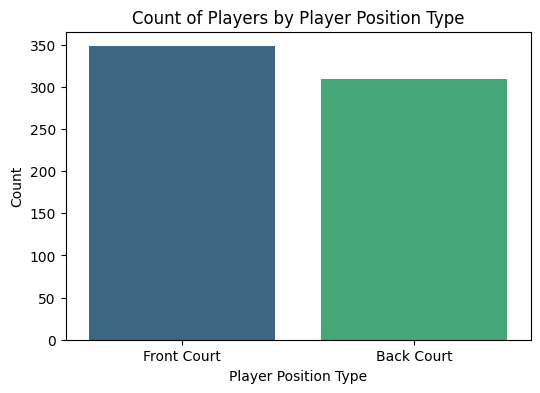

(POS
 Front Court    348
 Back Court     309
 Name: count, dtype: int64,
                   PPG       RPG       APG       USG%      eFG%       TS%
 POS                                                                     
 Back Court   8.170550  2.481877  2.453074  18.584142  0.491324  0.523149
 Front Court  8.129598  3.984483  1.508621  17.400000  0.524500  0.549698)

In [15]:
#update to simplify positions into "Back Court" and "Front Court"
df['POS'] = df['POS'].replace({
    'G-F': 'Back Court',
    'F-G': 'Back Court',
    'G': 'Back Court',
    'F': 'Front Court',
    'C': 'Front Court',
    'F-C': 'Front Court',
    'C-F': 'Front Court'
})

# checking distribution of positions
position_distribution = df['POS'].value_counts()

# summary stats for performance metrics grouped by "Back Court" and "Front Court"
grouped_stats = df.groupby('POS')[['PPG', 'RPG', 'APG', 'USG%', 'eFG%', 'TS%']].mean()

# visualizing distribution of positions.
# they are fairly even!
plt.figure(figsize=(6, 4))
sns.barplot(x=position_distribution.index, y=position_distribution.values, palette='viridis')
plt.title("Count of Players by Player Position Type")
plt.xlabel("Player Position Type")
plt.ylabel("Count")
plt.show()

position_distribution, grouped_stats


Now we add the all star value to all star players of last year in the dataframe. This way, we can classify which players were all stars and which weren't.

In [16]:
all_star_players = [
    "LeBron James", "Giannis Antetokounmpo", "Jayson Tatum", "Donovan Mitchell",
    "Kyrie Irving", "Luka Doncic", "Nikola Jokic", "Joel Embiid", "Ja Morant",
    "Lauri Markkanen", "Bam Adebayo", "Jaylen Brown", "DeMar DeRozan",
    "Tyrese Haliburton", "Jrue Holiday", "Julius Randle", "Pascal Siakam",
    "Anthony Edwards", "De'Aaron Fox", "Paul George", "Shai Gilgeous-Alexander",
    "Jaren Jackson Jr.", "Damian Lillard", "Domantas Sabonis"
]
df['All_Star'] = df['NAME'].apply(lambda name: 1 if name in all_star_players else 0)


# **Exploratory Data Analysis**



T-Test: Comparing PPG between Back Court and Front Court
t-statistic: 0.078
p-value: 0.93755


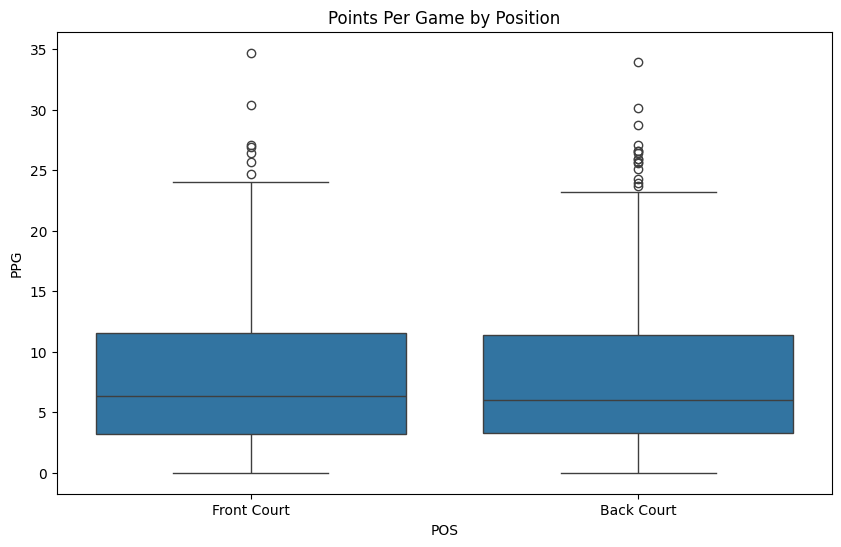

Null Hypothesis: There is little difference in points scored between guards and big men for the 2023-2024 NBA season.
Alternative Hypothesis: There is a significant difference in points scored between guards and big men for the 2023-2024 NBA season.
As the p-value is much greater than a significance level that we like (0.05), we should fail to reject the null hypothesis.
Conclusion 1:
There is no significant difference in scoring between guards and big men in the 2023-24 NBA season.


In [30]:
# test #1
print("\n\nT-Test: Comparing PPG between Back Court and Front Court")

# grouping by position
guards = df[df['POS'].isin(['Back Court'])]['PPG']
bigs = df[df['POS'].isin(['Front Court'])]['PPG']

t_stat, t_p = ttest_ind(guards, bigs)
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {t_p:.5f}")


plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['POS'].isin(['Back Court', 'Front Court'])], x='POS', y='PPG')
plt.title('Points Per Game by Position')
plt.show()


print("Null Hypothesis: There is little difference in points scored between guards and big men for the 2023-2024 NBA season.")
print("Alternative Hypothesis: There is a significant difference in points scored between guards and big men for the 2023-2024 NBA season.")
print("As the p-value is much greater than a significance level that we like (0.05), we should fail to reject the null hypothesis.")
print("Conclusion 1:")
print("There is no significant difference in scoring between guards and big men in the 2023-24 NBA season.")




ANOVA Test: Comparing TS% across all positions
F-statistic: 6.983
p-value: 0.00842
Mean TS% for Front Court: 0.550
Mean TS% for Back Court: 0.523


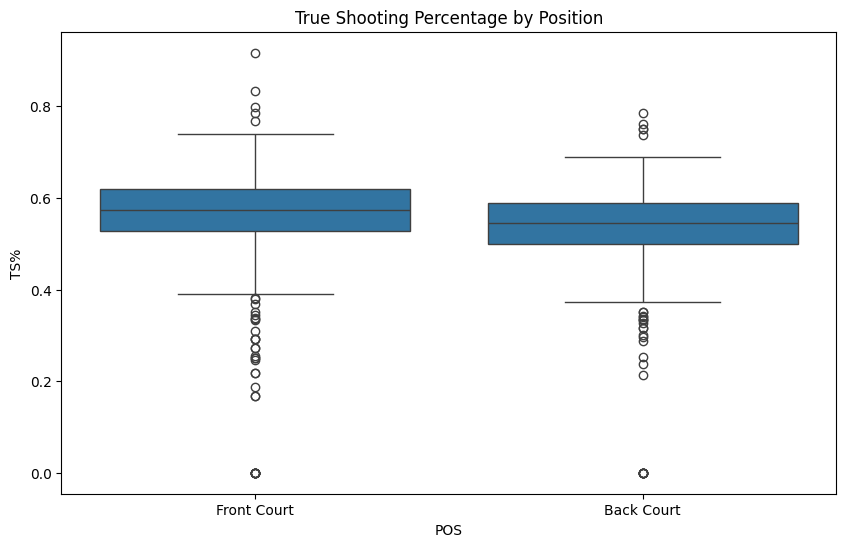

Null Hypothesis: There are little differences in shooting efficiency (TS%) across different positions.
Alternative Hypothesis: There are significant differences in shooting efficiency (TS%) across different positions.
As the p-value is less than a significance level that we like (0.05), we reject the null hypothesis.
Conclusion 2:
There are significant differences in shooting efficiency (TS%) across different positions.
Thus, we can conclude that big men (forwards, centers) have better shooting efficiency than guards. This may be because they take more shots closer to the basket.


In [31]:
# test #2
print("\n\nANOVA Test: Comparing TS% across all positions")

# grouping by position
pos_groups = [group['TS%'].values for name, group in df.groupby('POS')]
f_stat, anova_p = f_oneway(*pos_groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {anova_p:.5f}")

for pos in df['POS'].unique():
    mean_ts = df[df['POS'] == pos]['TS%'].mean()
    print(f"Mean TS% for {pos}: {mean_ts:.3f}")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='POS', y='TS%')
plt.title('True Shooting Percentage by Position')
plt.show()

print("Null Hypothesis: There are little differences in shooting efficiency (TS%) across different positions.")
print("Alternative Hypothesis: There are significant differences in shooting efficiency (TS%) across different positions.")
print("As the p-value is less than a significance level that we like (0.05), we reject the null hypothesis.")
print("Conclusion 2:")
print("There are significant differences in shooting efficiency (TS%) across different positions.")
print("Thus, we can conclude that big men (forwards, centers) have better shooting efficiency than guards. This may be because they take more shots closer to the basket.")




Chi-Square Test: Position vs Scoring Category
chi-square statistic: 1.306
p-value: 0.52058


<Figure size 1000x600 with 0 Axes>

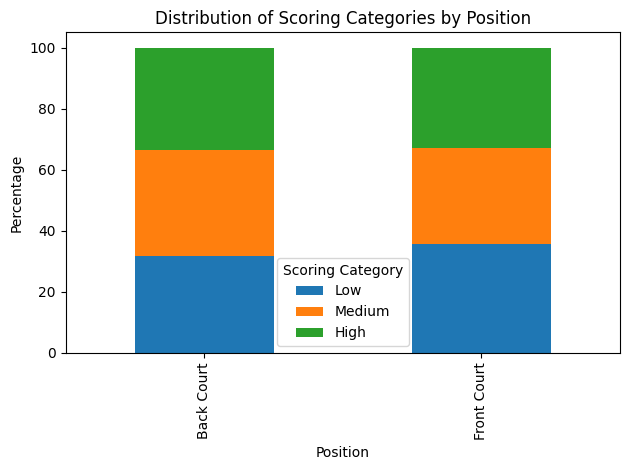

Null Hypothesis: There is no significant association between a player's position and their scoring output.
Alternative Hypothesis: There is a significant association between a player's position and their scoring output.
As the p-value is greater than a significance level that we like (0.05), we fail to reject the null hypothesis.
Conclusion 3:
There is no significant association between a player's position and their scoring output.
We can see low, high, medium scorers across all positions


In [32]:
# test #3
print("\n\nChi-Square Test: Position vs Scoring Category")

# making new scoring types column
df['Scoring_Category'] = pd.qcut(df['PPG'], q=3, labels=['Low', 'Medium', 'High'])

contingency = pd.crosstab(df['POS'], df['Scoring_Category'])
chi2, chi2_p, dof, expected = chi2_contingency(contingency)
print(f"chi-square statistic: {chi2:.3f}")
print(f"p-value: {chi2_p:.5f}")

plt.figure(figsize=(10, 6))
contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100
contingency_pct.plot(kind='bar', stacked=True)
plt.title('Distribution of Scoring Categories by Position')
plt.xlabel('Position')
plt.ylabel('Percentage')
plt.legend(title='Scoring Category')
plt.tight_layout()
plt.show()


print("Null Hypothesis: There is no significant association between a player's position and their scoring output.")
print("Alternative Hypothesis: There is a significant association between a player's position and their scoring output.")
print("As the p-value is greater than a significance level that we like (0.05), we fail to reject the null hypothesis.")
print("Conclusion 3:")
print("There is no significant association between a player's position and their scoring output.")
print("We can see low, high, medium scorers across all positions")


# **Primary Analysis**

Now, we will use a random forest classifier to determine which metrics are most critical for predicting all star status. We split the data into 80% training and 20% testing.

<ipython-input-18-05c0bfe078d8>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


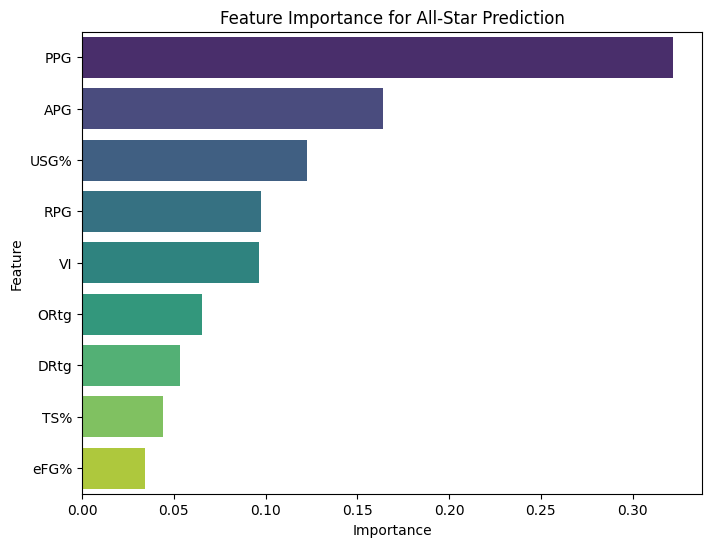

,Feature,Importance
0,PPG,0.321794
2,APG,0.164205
3,USG%,0.122403
1,RPG,0.097684
6,VI,0.096305
7,ORtg,0.065230
8,DRtg,0.053501
5,TS%,0.044313
4,eFG%,0.034566


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# selecting relevant features and target
features = ['PPG', 'RPG', 'APG', 'USG%', 'eFG%', 'TS%', 'VI', 'ORtg', 'DRtg']
X = df[features]
y = df['All_Star']

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#scale features for consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#training model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

#getting importance
feature_importance = rf_model.feature_importances_

#making df for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

#visualizing importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for All-Star Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

importance_df


Key Metrics:

PPG (Points Per Game): The most important feature, with 32% contribution to the model, indicating that scoring is a strong predictor of All-Star status.

APG (Assists Per Game): Second most significant (16%), reflecting the value of playmaking.

USG% (Usage Rate): Highlights the importance of a player's role in offensive possessions (12%).

RPG (Rebounds Per Game): 9.8%, showing some emphasis on rebounding for All-Stars.

From the visualization, we can see that points per game has the biggest impact on all star selection. Now that we know that PPG has the biggest impact on all star selection, we will use players that rank top 80 in PPG.

Using clustering, we will now group players into similar profiles using metrics such as points per game, rebounds per game, etc. Through this clustering, we can identify players with similar stats across various features and group them together, even if they differ in positions or team roles.

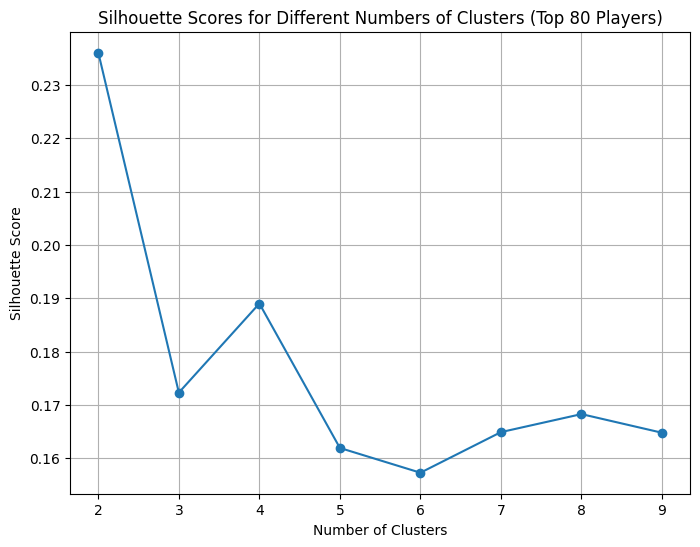

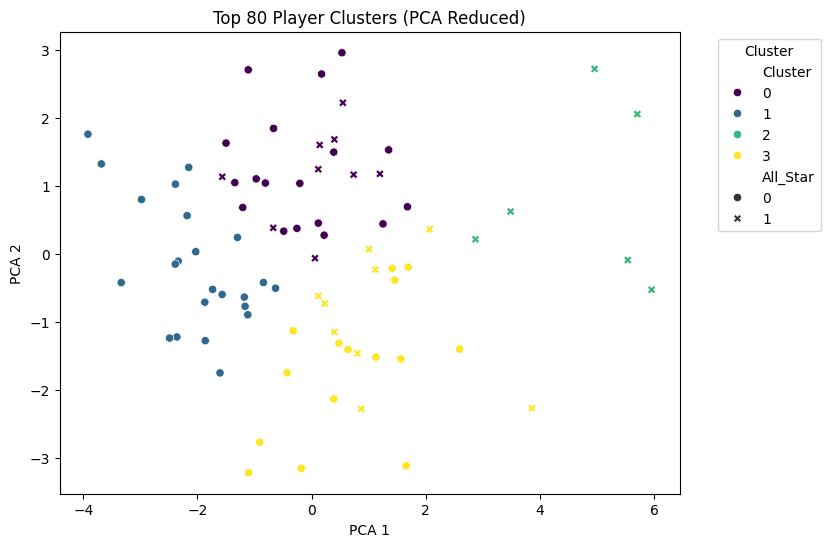

In [39]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# filtering dataset for the top 80 players by PPG
top_80_ppg_df = df.nlargest(80, 'PPG').reset_index(drop=True)

#key features for clustering among the top 80 players
clustering_features = ['PPG', 'RPG', 'APG', 'USG%', 'eFG%', 'TS%', 'VI', 'ORtg', 'DRtg']
X_top_80_clustering = scaler.fit_transform(top_80_ppg_df[clustering_features])

#determining number of clusters
silhouette_scores_top_80 = []
range_n_clusters_top_80 = range(2, 10)
for n_clusters in range_n_clusters_top_80:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels_top_80 = kmeans.fit_predict(X_top_80_clustering)
    silhouette_scores_top_80.append(silhouette_score(X_top_80_clustering, cluster_labels_top_80))

#plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters_top_80, silhouette_scores_top_80, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters (Top 80 Players)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

#performing clustering; should be 4 based on the visualization
optimal_clusters_top_80 = 4
kmeans_top_80 = KMeans(n_clusters=optimal_clusters_top_80, random_state=42)
top_80_ppg_df['Cluster'] = kmeans_top_80.fit_predict(X_top_80_clustering)

#reducing dimensionality for visualization using PCA
pca_top_80 = PCA(n_components=2)
reduced_data_top_80 = pca_top_80.fit_transform(X_top_80_clustering)
top_80_ppg_df['PCA1'] = reduced_data_top_80[:, 0]
top_80_ppg_df['PCA2'] = reduced_data_top_80[:, 1]

# plotting cluster for top 80 ppg
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=top_80_ppg_df, palette='viridis', style='All_Star',
    markers={0: 'o', 1: 'X'}, legend='full'
)
plt.title("Top 80 Player Clusters (PCA Reduced)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



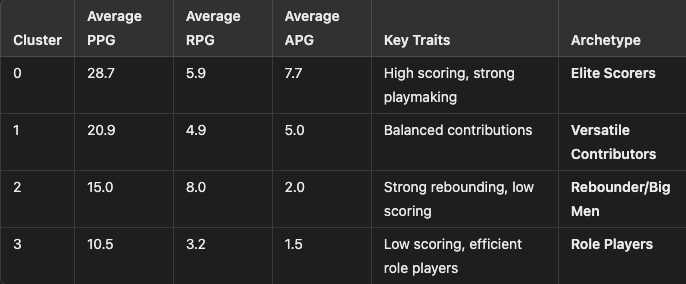

In [23]:
#redefine all stars and non all stars from the top 80 PPG players
all_stars = top_80_ppg_df[top_80_ppg_df['All_Star'] == 1]
non_all_stars = top_80_ppg_df[top_80_ppg_df['All_Star'] == 0]

#calculating mean metrics for All-Stars from the top 80 players
all_star_means = all_stars[clustering_features].mean()

#getting euclidian distances between all star and non all star averages
non_all_stars['Distance'] = non_all_stars[clustering_features].apply(
    lambda row: np.linalg.norm(row - all_star_means), axis=1
)

#sorting "snubbed" players by their distance to all star average
similar_non_all_stars = non_all_stars.sort_values(by='Distance').reset_index(drop=True)

# displaying top 5 most similar players that were "snubbed"
similar_non_all_stars[['NAME', 'TEAM', 'PPG', 'RPG', 'APG', 'TS%', 'ORtg', 'DRtg', 'Distance', 'POS', 'GP']].head(7)


<ipython-input-23-32652c383622>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_all_stars['Distance'] = non_all_stars[clustering_features].apply(


,NAME,TEAM,PPG,RPG,APG,TS%,ORtg,DRtg,Distance,POS,GP
0,Zion Williamson,Nor,22.9,5.8,5.0,0.610,118.8,108.8,3.496760,Front Court,70
1,Kevin Durant,Pho,27.1,6.6,5.0,0.626,117.8,112.8,4.300460,Front Court,75
2,Devin Booker,Pho,27.1,4.5,6.9,0.611,123.9,110.6,5.306720,Back Court,68
3,Jamal Murray,Den,21.2,4.1,6.5,0.586,119.1,112.3,5.865705,Back Court,59
4,Tyrese Maxey,Phi,25.9,3.7,6.2,0.573,120.9,113.9,5.943960,Back Court,70
5,Stephen Curry,Gol,26.4,4.5,5.1,0.616,118.9,114.9,6.270163,Back Court,74
6,Desmond Bane,Mem,23.7,4.4,5.5,0.589,114.3,110.8,6.986516,Back Court,42


From the list of 7 players who were not selected as all stars but are the closest to their all star peers, Zion Williamson, Kevin Durant and Stephen Curry were all selected as all stars but missed the game due to injury.

In [26]:
# filtering out injured players
excluded_players = ['Zion Williamson', 'Kevin Durant', 'Stephen Curry']

filtered_similar_non_all_stars = similar_non_all_stars[
    ~similar_non_all_stars['NAME'].isin(excluded_players)
]

filtered_similar_non_all_stars[['NAME', 'TEAM', 'PPG', 'RPG', 'APG', 'TS%', 'ORtg', 'DRtg', 'Distance', 'POS', 'GP']].head(4)


,NAME,TEAM,PPG,RPG,APG,TS%,ORtg,DRtg,Distance,POS,GP
2,Devin Booker,Pho,27.1,4.5,6.9,0.611,123.9,110.6,5.306720,Back Court,68
3,Jamal Murray,Den,21.2,4.1,6.5,0.586,119.1,112.3,5.865705,Back Court,59
4,Tyrese Maxey,Phi,25.9,3.7,6.2,0.573,120.9,113.9,5.943960,Back Court,70
6,Desmond Bane,Mem,23.7,4.4,5.5,0.589,114.3,110.8,6.986516,Back Court,42


Without the all star players who were out due to injury, all that remains of the top 7 "snubbed" players are Devin Booker, Jamal Murray, Tyrese Maxey, and Desmond Bane, who are all back court players. These players are either point guards or shooting guards.

# **Insights and Conclusions**

After this analysis, among the top 7 "snubbed" players(those statistically closest to All-Stars), the remaining candidates after excluding injury-related absences are:

Devin Booker (Phoenix Suns)

Jamal Murray (Denver Nuggets)

Tyrese Maxey (Philadelphia 76ers)

Desmond Bane (Memphis Grizzlies)

All four players are Back Court players (point guards or shooting guards). We can conclude that back court players are more likely to be "snubbed" in all star game selection. Therefore, we reject the null hypothesis and show that there is a correlation between a player's position and all star selection.

To add more context to this study, we can see that the cluster analysis shows elite guards dominate metrics such as PPG and APG, which align closely with all star selection criteria. The importatant consideration of this is that most teams have back court players who are responsible for scoring and playmaking which can cause higher volume of back court talent, which causes deserving players to be unselected.

**Final Conclusion**

The back court players experience more competition for all star spots, as shown by the list of snubbed players.

The front court players appear to have less competition among elite players, making it easier for top-performing forwards and centers to secure all star spots.

